# How to Train YOLOv5 on Custom Objects

This tutorial is based on the [YOLOv5 repository](https://github.com/ultralytics/yolov5) by [Ultralytics](https://www.ultralytics.com/). This notebook shows training on **your own custom objects**. Many thanks to Ultralytics for putting this repository together - we hope that in combination with clean data management tools at Roboflow, this technologoy will become easily accessible to any developer wishing to use computer vision in their projects.

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [how to train YOLOv5](https://blog.roboflow.ai/how-to-train-yolov5-on-a-custom-dataset/), concurrently.

### Steps Covered in this Tutorial

In this tutorial, we will walk through the steps required to train YOLOv5 on your custom objects. We use a [public blood cell detection dataset](https://public.roboflow.ai/object-detection/bccd), which is open source and free to use. You can also use this notebook on your own data.

To train our detector we take the following steps:

* Install YOLOv5 dependencies
* Download custom YOLOv5 object detection data
* Write our YOLOv5 Training configuration
* Run YOLOv5 training
* Evaluate YOLOv5 performance
* Visualize YOLOv5 training data
* Run YOLOv5 inference on test images
* Export saved YOLOv5 weights for future inference



### **About**

[Roboflow](https://roboflow.com) enables teams to deploy custom computer vision models quickly and accurately. Convert data from to annotation format, assess dataset health, preprocess, augment, and more. It's free for your first 1000 source images.

**Looking for a vision model available via API without hassle? Try Roboflow Train.**

![Roboflow Wordmark](https://i.imgur.com/dcLNMhV.png)



#Install Dependencies

_(Remember to choose GPU in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> GPU)_

In [9]:
%cd ~/cloudfiles/code/Users/dnn200001
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5


/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-inference/code/Users/dnn200001
fatal: destination path 'yolov5' already exists and is not an empty directory.
/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-inference/code/Users/dnn200001/yolov5


In [10]:
!git reset --hard fbe67e465375231474a2ad80a4389efc77ecff99

HEAD is now at fbe67e4 Fix `OMP_NUM_THREADS=1` for macOS (#8624)


In [1]:
%cd ~/cloudfiles/code/Users/dnn200001/yolov5/
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-inference/code/Users/dnn200001/yolov5
Setup complete. Using torch 1.8.1+cu102 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


# Download Correctly Formatted Custom Dataset 

We'll download our dataset from Roboflow. Use the "**YOLOv5 PyTorch**" export format. Note that the Ultralytics implementation calls for a YAML file defining where your training and test data is. The Roboflow export also writes this format for us.

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).



![YOLOv5 PyTorch export](https://i.imgur.com/5vr9G2u.png)


In [2]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
#rf = Roboflow(model_format='yolov5', notebook='ultralytics')

In [3]:
#after following the link above, recieve python code with these fields filled in
from roboflow import Roboflow
rf = Roboflow(api_key="7a6JyHXqpG4n1fRVjnP1")
project = rf.workspace("roboflow-universe-projects").project("basketball-players-fy4c2")
dataset = project.version(16).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Basketball-Players-16 in yolov5pytorch:: 100%|██████████| 2070/2070 [02:00<00:00, 17.24it/s]


In [4]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- Ball
- Hoop
- Period
- Player
- Ref
- Shot Clock
- Team Name
- Team Points
- Time Remaining
nc: 9
roboflow:
  license: CC BY 4.0
  project: basketball-players-fy4c2
  url: https://universe.roboflow.com/roboflow-universe-projects/basketball-players-fy4c2/dataset/16
  version: 16
  workspace: roboflow-universe-projects
test: ../test/images
train: Basketball-Players-16/train/images
val: Basketball-Players-16/valid/images


# Define Model Configuration and Architecture

We will write a yaml script that defines the parameters for our model like the number of classes, anchors, and each layer.

You do not need to edit these cells, but you may.

In [4]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [5]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

cat: /content/yolov5/models/yolov5s.yaml: No such file or directory


In [6]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
# #This code block doesn't work. Need to make a custom_yolov5s.yaml and change {num_classes} to 9
# #uncomment by Cltr+A then Cltr + '/' if it somehow work

# %%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# # parameters
# nc: {num_classes}  # number of classes
# depth_multiple: 0.33  # model depth multiple
# width_multiple: 0.50  # layer channel multiple

# # anchors
# anchors:
#   - [10,13, 16,30, 33,23]  # P3/8
#   - [30,61, 62,45, 59,119]  # P4/16
#   - [116,90, 156,198, 373,326]  # P5/32

# # YOLOv5 backbone
# backbone:
#   # [from, number, module, args]
#   [[-1, 1, Focus, [64, 3]],  # 0-P1/2
#    [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
#    [-1, 3, BottleneckCSP, [128]],
#    [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
#    [-1, 9, BottleneckCSP, [256]],
#    [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
#    [-1, 9, BottleneckCSP, [512]],
#    [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
#    [-1, 1, SPP, [1024, [5, 9, 13]]],
#    [-1, 3, BottleneckCSP, [1024, False]],  # 9
#   ]

# # YOLOv5 head
# head:
#   [[-1, 1, Conv, [512, 1, 1]],
#    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
#    [[-1, 6], 1, Concat, [1]],  # cat backbone P4
#    [-1, 3, BottleneckCSP, [512, False]],  # 13

#    [-1, 1, Conv, [256, 1, 1]],
#    [-1, 1, nn.Upsample, [None, 2, 'nearest']],
#    [[-1, 4], 1, Concat, [1]],  # cat backbone P3
#    [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

#    [-1, 1, Conv, [256, 3, 2]],
#    [[-1, 14], 1, Concat, [1]],  # cat head P4
#    [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

#    [-1, 1, Conv, [512, 3, 2]],
#    [[-1, 10], 1, Concat, [1]],  # cat head P5
#    [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

#    [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
#   ]

# Train Custom YOLOv5 Detector

### Next, we'll fire off training!


Here, we are able to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights. (Note: you can download weights from the Ultralytics Google Drive [folder](https://drive.google.com/open?id=1Drs_Aiu7xx6S-ix95f9kNsA6ueKRpN2J))
- **name:** result names
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

In [7]:
%%time
# train yolov5s on custom data for 100 epochs
# time its performance

%cd ~/cloudfiles/code/Users/dnn200001/yolov5/
!python train.py --img 640 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-inference/code/Users/dnn200001/yolov5
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-inference/code/Users/dnn200001/yolov5/Basketball-Players-16/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 498 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-306-gfbe67e4 Python-3.8.10 torch-1.8.1+cu

# Evaluate Custom YOLOv5 Detector Performance

Training losses and performance metrics are saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`. (If given no name, it defaults to `results.txt`.) The results file is plotted as a png after training completes.

Note from Glenn: Partially completed `results.txt` files can be plotted with `from utils.utils import plot_results; plot_results()`.

In [13]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

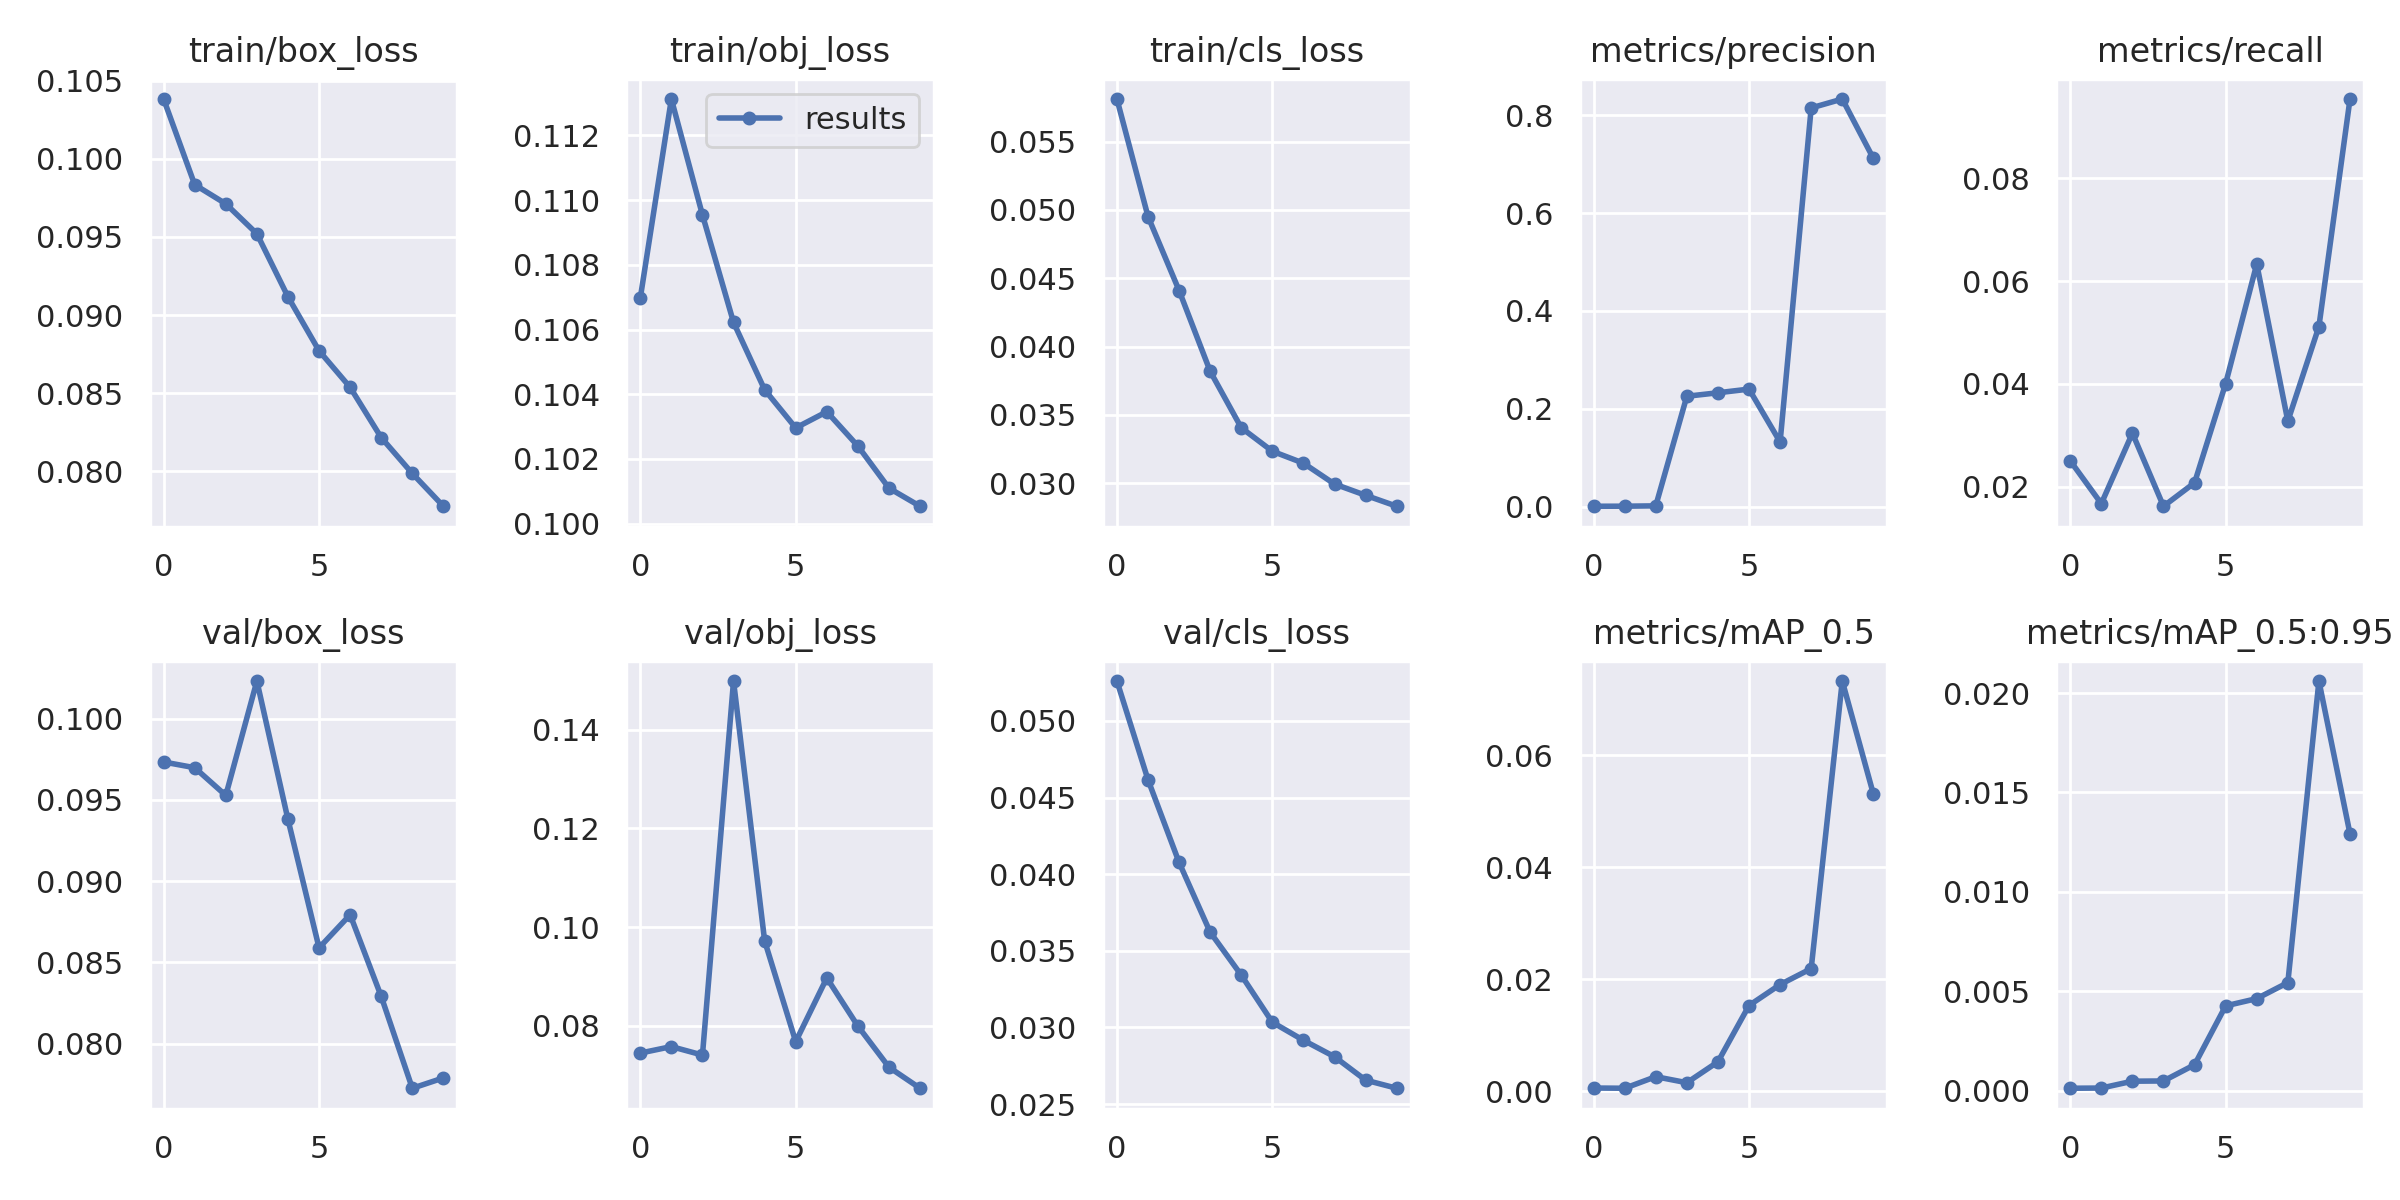

In [14]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

### Curious? Visualize Our Training Data with Labels

After training starts, view `train*.jpg` images to see training images, labels and augmentation effects.

Note a mosaic dataloader is used for training (shown below), a new dataloading concept developed by Glenn Jocher and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

In [15]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/test_batch0_labels.jpg', width=900)

GROUND TRUTH TRAINING DATA:


FileNotFoundError: ignored

GROUND TRUTH AUGMENTED TRAINING DATA:


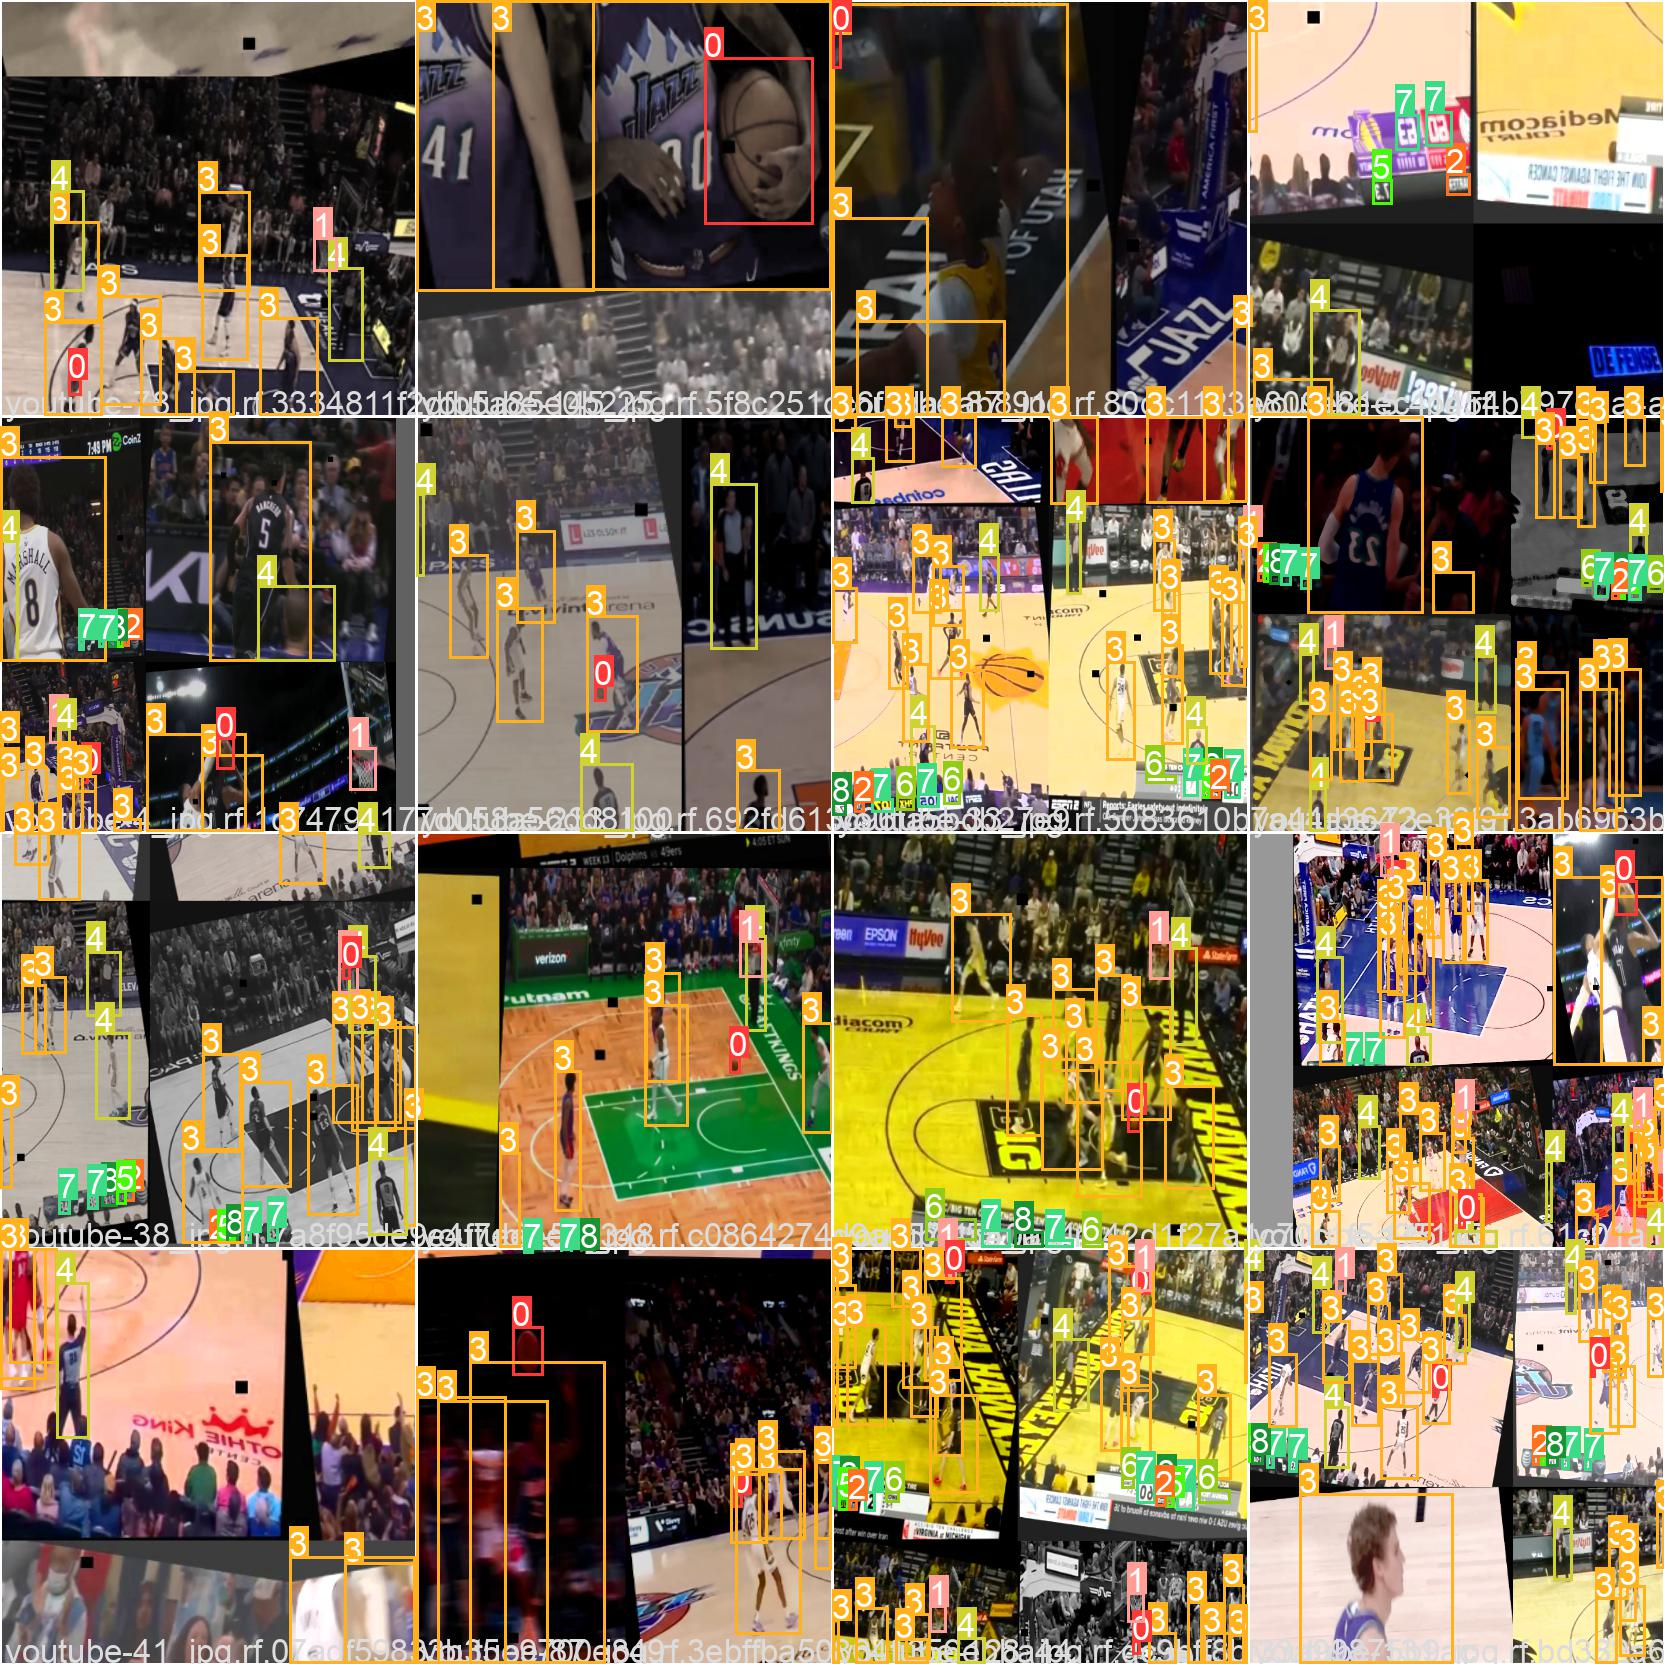

In [16]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

#Run Inference  With Trained Weights
Run inference with a pretrained checkpoint on contents of `test/images` folder downloaded from Roboflow.

In [ ]:
# when we ran this, we saw .007 second inference time. That is 140 FPS on a TESLA P100!
# use the best weights!
%cd ~/cloudfiles/code/Users/dnn200001/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source ../test/images

In [ ]:
#display inference on ALL test images
#this looks much better with longer training above

import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

## Congrats!

Hope you enjoyed this!

--Team [Roboflow](https://roboflow.ai)